In [56]:
# import all libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
import argparse

In [120]:
torch.manual_seed(0)
# these are commonly used data augmentations
# random cropping and random horizontal flip
# lastly, we normalize each channel into zero mean and unit standard deviation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


tempset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

trainset, valset = data.random_split(tempset, [40000, 10000], generator= torch.Generator().manual_seed(0))

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

validloader = torch.utils.data.DataLoader(
    valset, batch_size=128, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=False, transform=transform_test)

# we can use a larger batch size during test, because we do not save 
# intermediate variables for gradient computation, which leaves more memory
testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [132]:
train_indices, val_indices = train_test_split(list(range(len(tempset.targets))), test_size=0.2, random_state = 0, stratify=tempset.targets)
trainset = torch.utils.data.Subset(tempset, train_indices)
valset = torch.utils.data.Subset(tempset, val_indices)

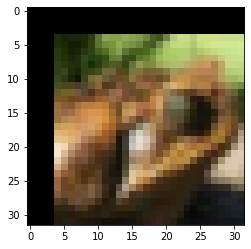

In [133]:
plt.imshow(trainset[4][0].permute(1,2,0))

In [134]:
count_temp = np.zeros(len(classes))
count_train = np.zeros(len(classes))

for im, label in trainset:
    count_temp[label] += 1
    count_train[label] += 1

for im, label in valset:
    count_temp[label] += 1


<BarContainer object of 10 artists>

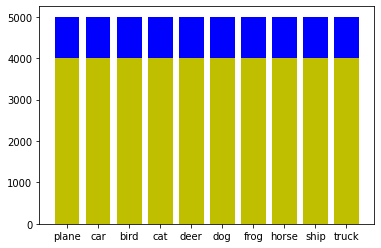

In [135]:

plt.bar(classes, count_temp, color = 'b', label = 'lala')
plt.bar(classes, count_train, color = 'y', label = 'haha')

In [136]:


np.array([4014., 4002., 3995., 3977., 3982., 4019., 3975., 4010., 4010.,
       4016.]);

count_train

array([4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000.,
       4000.])

In [137]:
# Training
def train(epoch, net, criterion, trainloader, scheduler, optimizer):
    device = 'cuda'
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx+1) % 50 == 0:
          print("iteration : %3d, loss : %0.4f, accuracy : %2.2f" % (batch_idx+1, train_loss/(batch_idx+1), 100.*correct/total))

    #scheduler.step()
    return train_loss/(batch_idx+1), 100.*correct/total

def test(epoch, net, criterion, testloader):
    device = 'cuda'
    net.eval()
    valid_loss = 0
    correct = 0
    total = 0
    with torch.inference_mode():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return valid_loss/(batch_idx+1), 100.*correct/total



In [152]:
def save_checkpoint(net, acc, epoch):
    # Save checkpoint.
    print('Saving..')
    state = {
        'net': net.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.pth')

def save_result(name, train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc):
    print('Saving..')
    state = {
        'tl': train_loss,
        'vl': valid_loss,
        'fl': test_loss,
        'ta': train_acc,  
        'va': valid_acc,  
        'fa': test_acc,
    }

    if not os.path.isdir('result'):
        os.mkdir('result')
    torch.save(state, f'./result/{name}.pth')

In [139]:
# defining resnet models

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # This is the "stem"
        # For CIFAR (32x32 images), it does not perform downsampling
        # It should downsample for ImageNet
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # four stages with three downsampling
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test_resnet18():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

In [140]:
# main body
config = {
    'lr': 0.1,
    'momentum': 0.9,
    'weight_decay': 0#5e-4
}

train_loss_ls = []
train_acc_ls = []
valid_loss_ls = []
valid_acc_ls = []

net = ResNet18().to('cuda')
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.SGD(net.parameters(), lr=config['lr'],
                      momentum=config['momentum'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

for epoch in range(0, 15):
    train_loss, train_acc = train(epoch, net, criterion, trainloader, scheduler, optimizer)
    valid_loss, valid_acc = test(epoch, net, criterion, validloader)
    
    print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, validation loss " + \
      ": %0.4f, validation accuracy : %2.2f") % (epoch, train_loss, train_acc, valid_loss, valid_acc))

    train_loss_ls.append(train_loss)
    valid_loss_ls.append(valid_loss)
    train_acc_ls.append(train_acc)
    valid_acc_ls.append(valid_acc) 

#Finally, get the test result
test_loss, test_acc = test(epoch, net, criterion, testloader)
save_result('lr01', train_loss_ls, valid_loss_ls,  test_loss, train_acc_ls, valid_acc_ls,test_acc)


Epoch: 0
iteration :  50, loss : 1.9619, accuracy : 27.69
iteration : 100, loss : 1.8138, accuracy : 33.15
iteration : 150, loss : 1.6996, accuracy : 37.32
iteration : 200, loss : 1.6211, accuracy : 40.21
iteration : 250, loss : 1.5632, accuracy : 42.44
iteration : 300, loss : 1.5030, accuracy : 44.81
Epoch :   0, training loss : 1.4876, training accuracy : 45.42, validation loss : 1.8369, validation accuracy : 43.08

Epoch: 1
iteration :  50, loss : 1.1336, accuracy : 59.14
iteration : 100, loss : 1.1130, accuracy : 60.18
iteration : 150, loss : 1.0885, accuracy : 61.00
iteration : 200, loss : 1.0739, accuracy : 61.62
iteration : 250, loss : 1.0570, accuracy : 62.32
iteration : 300, loss : 1.0394, accuracy : 62.96
Epoch :   1, training loss : 1.0357, training accuracy : 63.11, validation loss : 1.4888, validation accuracy : 50.96

Epoch: 2
iteration :  50, loss : 0.8607, accuracy : 70.02
iteration : 100, loss : 0.8731, accuracy : 69.34
iteration : 150, loss : 0.8603, accuracy : 69.68

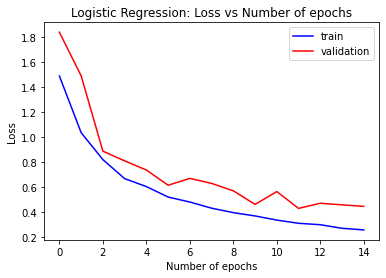

In [141]:
#temp = torch.load('./result/lr001.pth')

plt.plot(range(len(train_loss_ls)), train_loss_ls, 'b')
plt.plot(range(len(valid_loss_ls)), valid_loss_ls, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Logistic Regression: Loss vs Number of epochs")
plt.legend(['train', 'validation'])
plt.show()

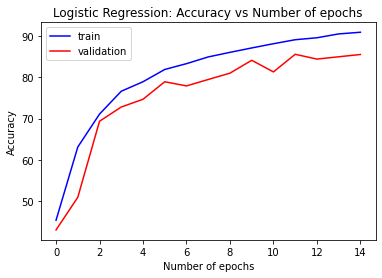

In [163]:
plt.plot(range(len(train_acc_ls)), train_acc_ls, 'b')
plt.plot(range(len(valid_acc_ls)), valid_acc_ls, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Logistic Regression: Accuracy vs Number of epochs")
plt.legend(['train', 'validation'])
plt.show()

In [164]:
test_loss, test_acc

(0.4431472051888704, 85.9)